## Movies Recommender System with Collaborative Filtering and Neural Network

In [1]:
use_small_data = True # the complete dataset is too large
data_dir = "./data/ml-latest-small" if use_small_data else "./data/ml-latest"
file_name = "ratings.csv"
file_path = data_dir + "/" + file_name

In [2]:
import pandas as pd 
import numpy as np 

from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split

In [3]:
reader = Reader()
cols = ['user_ids', 'item_ids', 'ratings', 'timestamps']
data = pd.read_csv(file_path, names=cols, header=1)
print(data.head())
print(len(data))

   user_ids  item_ids  ratings  timestamps
0         1         3      4.0   964981247
1         1         6      4.0   964982224
2         1        47      5.0   964983815
3         1        50      5.0   964982931
4         1        70      3.0   964982400
100835


Keep 20000 data points for final test

In [4]:
num_final_test = 20000
shuffled_data = data.sample(frac=1) # randomly shuffle the data
shuffled_data[-num_final_test:].to_csv(data_dir + "/" +"ratings_final_test.csv")
shuffled_data[:-num_final_test+1].to_csv(data_dir + "/" +"ratings_train_valid.csv")

In [5]:
len(data) # the original dataset contains 100835 data points

100835

In [6]:
print(data.user_ids.max()) # 610 users
print(data.item_ids.max()) # 193609 items
print(np.unique(data.item_ids.values).shape) # 9724 unique items

610
193609
(9724,)


Reload the data for training and validation. 

Initialize SVD by Simon Funk https://surprise.readthedocs.io/en/stable/matrix_factorization.html#

In [7]:
data = pd.read_csv(data_dir + "/" +"ratings_train_valid.csv", names=cols, header=1)
print(len(data))
dataset = Dataset.load_from_df(data[['user_ids', 'item_ids', 'ratings']], reader)
svd = SVD(reg_all=0.15)

80835


In [8]:
def compute_mse(pred, label):
    pred, ref = np.array(pred), np.array(label)
    return np.mean((pred-ref)**2)

def pred_results(algo, testset):
    output = algo.test(testset)
    preds = [x.est for x in output]
    labels = [x.r_ui for x in output]
    return preds, labels

In [9]:
trainset, validset = train_test_split(dataset, test_size=0.25, shuffle=True)
train_preds, train_labels = pred_results(svd.fit(trainset), trainset.build_testset())
print("MSE on Train Set {}".format(compute_mse(train_preds, train_labels)))
valid_preds, valid_labels = pred_results(svd, validset) # svd is already trained above
print("MSE on Validation Set {}".format(compute_mse(valid_preds, valid_labels)))

MSE on Train Set 0.6363121025358941
MSE on Validation Set 0.7715911458162505


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [11]:
class RatingDataset(TensorDataset):

    train_set_proportion = 0.75

    def __init__(self, file_path, set_type="train"):

        cols = ['user_ids', 'item_ids', 'ratings', 'timestamps']
        # frac=1 means random shuffle, use a fixed random state here to make sure the training
        # and validation set uses the same shuffle
        df = pd.read_csv(file_path, names=cols, header=1).sample(frac=1, random_state=875581)
        split_idx = round(len(df)*self.train_set_proportion)
        
        self.n_users = 610
        self.n_items = 193609

        if set_type=="train": # train set, load first 75% (after shuffle)
            print("Loading training data")
            user_ids = torch.LongTensor(df.user_ids.values[:split_idx])
            item_ids = torch.LongTensor(df.item_ids.values[:split_idx])
            ratings = torch.Tensor(df.ratings.values[:split_idx])
        elif set_type == "valid": # validation set, load last 25% (after shuffle)
            print("Loading validation data")
            user_ids = torch.LongTensor(df.user_ids.values[split_idx:])
            item_ids = torch.LongTensor(df.item_ids.values[split_idx:])
            ratings = torch.Tensor(df.ratings.values[split_idx:])
        elif set_type == "test":# test set, load all the items
            print("Loading testing data")
            user_ids = torch.LongTensor(df.user_ids.values)
            item_ids = torch.LongTensor(df.item_ids.values)
            ratings = torch.Tensor(df.ratings.values)

        super(RatingDataset, self).__init__(user_ids, item_ids, ratings)

In [12]:
trainset = RatingDataset(data_dir + "/" +"ratings_train_valid.csv", "train")
testset = RatingDataset(data_dir + "/" +"ratings_train_valid.csv", "valid")

Loading training data
Loading validation data


In [13]:
class RecommenderSystem(nn.Module):
    def __init__(self, n_users, n_items, n_embed=50, 
                 dropout_rate=0.2, hidden_neurons=[10]):
        """
        Args:
          n_users: Number of users.
          n_items: Number of items.
        """
        super(RecommenderSystem, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_embed)
        self.item_emb = nn.Embedding(n_items, n_embed)
        
        hidden_block = []
        last_output = n_embed*2
        for n_hidden in hidden_neurons:
            hidden_block.append(nn.Linear(last_output, n_hidden))
            hidden_block.append(nn.Tanh())
            hidden_block.append(nn.Dropout(p=dropout_rate))
            last_output = n_hidden
        self.hidden_block = nn.Sequential(*hidden_block)
        del hidden_block 
        
        self.output_layer = nn.Linear(last_output, 1)
        
    def forward(self, user_ids, item_ids):
        """
        Args:
          user_ids of shape (batch_size): User ids (starting from 1).
          item_ids of shape (batch_size): Item ids (starting from 1).
        
        Returns:
          outputs of shape (batch_size): Predictions of ratings.
        """
        user_feat = self.user_emb(user_ids-1)
        item_feat = self.item_emb(item_ids-1)
        x = torch.cat([user_feat, item_feat], dim=1)
        x = self.hidden_block(x)
        x = self.output_layer(x)
        return torch.squeeze(x)
        

In [14]:
# Create the model
n_embed=40
dropout_rate=0.2
hidden_neurons = [10]
model = RecommenderSystem(trainset.n_users, trainset.n_items, n_embed, dropout_rate, hidden_neurons)
print(model)

RecommenderSystem(
  (user_emb): Embedding(610, 40)
  (item_emb): Embedding(193609, 40)
  (hidden_block): Sequential(
    (0): Linear(in_features=80, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
  )
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)


In [15]:
import copy

def test_current_model(model, testloader, creterion):
    model.eval().to(device)
    loss = 0
    for user_ids, item_ids, ratings in testloader:
        pred = model(user_ids.to(device), item_ids.to(device))
        loss += creterion(pred.cpu(), ratings).item()
    
    num_batches = round(len(testloader.dataset)/testloader.batch_size)
    
    return loss/num_batches
        
# hyper params
num_epochs = 30
learning_rate = 1e-2
weight_decay = 1e-3

# prepare data 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# loss function
creterion = nn.MSELoss()

# begin training
train_loss_list, test_loss_list = [], []
best_test_loss, best_weights = 875581, None 
for epoch in range(num_epochs):
    # to train mode
    model.train().to(device)
    for user_ids, item_ids, ratings in trainloader:
    
        pred = model(user_ids.to(device), item_ids.to(device))
        
        assert pred.shape == ratings.shape
        loss = creterion(pred.cpu(), ratings.to(torch.float32))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # compute current accuracy, will set the model to eval mode
    train_loss = test_current_model(model, trainloader, creterion)
    test_loss = test_current_model(model, testloader, creterion)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    print("Epoch {} Train Loss {} Test Loss {}".format(epoch, train_loss, test_loss))
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_weights = copy.deepcopy(model.state_dict())

model.load_state_dict(best_weights)
print("Loss of Best Model {}".format(test_current_model(model, testloader, creterion)))

Epoch 0 Train Loss 1.0670903052313854 Test Loss 1.0615747690200805
Epoch 1 Train Loss 0.9016437803284597 Test Loss 0.9031123369932175
Epoch 2 Train Loss 0.8770486166921713 Test Loss 0.8900965452194214
Epoch 3 Train Loss 0.8026664267152043 Test Loss 0.8354999423027039
Epoch 4 Train Loss 0.7671678248098341 Test Loss 0.8133370071649552
Epoch 5 Train Loss 0.7452201014858181 Test Loss 0.792378494143486
Epoch 6 Train Loss 0.7386478013911489 Test Loss 0.7927510619163514
Epoch 7 Train Loss 0.7119693857128337 Test Loss 0.7784744411706924
Epoch 8 Train Loss 0.7141533898094953 Test Loss 0.783584263920784
Epoch 9 Train Loss 0.6998528151188866 Test Loss 0.7742954820394516
Epoch 10 Train Loss 0.6938119166988438 Test Loss 0.7756566792726517
Epoch 11 Train Loss 0.6847810866469044 Test Loss 0.7688404381275177
Epoch 12 Train Loss 0.6730619982137518 Test Loss 0.765881335735321
Epoch 13 Train Loss 0.6776791740272005 Test Loss 0.7672890812158585
Epoch 14 Train Loss 0.669935068841708 Test Loss 0.76534317731

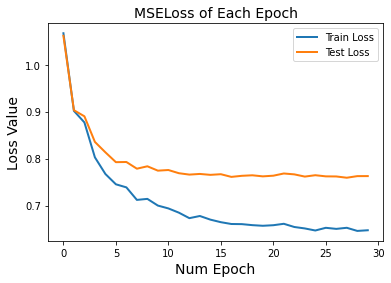

In [16]:
import matplotlib.pyplot as plt 
plt.plot(train_loss_list, linewidth=2, label="Train Loss");
plt.plot(test_loss_list, linewidth=2, label="Test Loss");
plt.title("MSELoss of Each Epoch", fontsize=14);
plt.xlabel("Num Epoch",fontsize=14);
plt.ylabel("Loss Value",fontsize=14);
plt.legend();

In [17]:
user_ids = [1, 100]
item_ids = [300, 10]

def predict_score(model, user_ids, item_ids):
    fx = lambda x: torch.Tensor(x).type(torch.long).to(device)
    return model(fx(user_ids), fx(item_ids)).cpu().detach().numpy()

predict_score(model, user_ids, item_ids)

array([4.1443124, 3.916524 ], dtype=float32)

In [18]:
final_testset = RatingDataset(data_dir + "/" +"ratings_final_test.csv", "test")
final_testloader = torch.utils.data.DataLoader(final_testset, batch_size=1024, shuffle=False)
print("Final Test Loss {}".format(test_current_model(model, final_testloader, creterion)))

Loading testing data
Final Test Loss 0.7729622155427933


### References

Data from https://grouplens.org/datasets/movielens/latest/

CS-C3240 Round 3 Material https://mycourses.aalto.fi/pluginfile.php/1415791/mod_page/content/23/CS-C3240_Round3_AnomalyDetection-OnlineLeaning-RecommenderSystems.pdf

A tutorial on recommender system https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

An example of collaborative filtering https://realpython.com/build-recommendation-engine-collaborative-filtering/

Pytorch embedding layer https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

CS-E4890 Deep learning Lecture 4 and corresponding assignment https://mycourses.aalto.fi/pluginfile.php/1436564/mod_resource/content/4/reg_all_slides.pdf

Python package Surprise https://github.com/NicolasHug/Surprise